# CSC/XMM validation catalogs, XMM/CSC hostless catalog

In [2]:
import sys
sys.path.append('../')

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table

matplotlib settings set


matplotlib settings set
matplotlib settings set


In [4]:
def csc_error_converter(df: pd.DataFrame,
                        r0_colname='err_ellipse_r0',
                        r1_colname='err_ellipse_r1') -> pd.DataFrame:
    """
    The function converts default radii `r0_colname`
    and `r1_colname` to the one-sigma error.

    Args:
        df (pd.DataFrame): DataFrame with `r0_colname` and
        `r1_colname` columns.
        
        r0_colname (str): major radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r0'.
        
        r1_colname (str): minor radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r1'.

    Returns:
        pd.DataFrame: one-sigma error in arcseconds.
    """

    # Conversion coefficient
    csc_sigma_coeff = np.sqrt(-(1 / (2 * np.log(1 - .95))))

    err_r1 = df[r0_colname]
    err_r2 = df[r1_colname]
    # Effective error
    csc_err_eff = np.sqrt(err_r1 ** 2 + err_r2 ** 2)

    csc_1sigma = csc_sigma_coeff * csc_err_eff

    return csc_1sigma


def vot2pd_csc(csc_cat_path: str,
               colnames: list,
               save_coords: bool = False, 
               radec_fits_name: str = 'cscresults_name_radec') -> pd.DataFrame:
    """
    The function converts the votable file to pandas DataFrame.

    Optionally saves the separate file with the coordinates and names of
    the CSC sources to the FITS file.

    Args:
        csc_cat_path (str): the path to the votable file.
        colnames (list): column names of the votable file.
        save_coords (bool): if True, saves the separate file with the coordinates
        and names of the CSC sources to the FITS file.
        radec_fits_name (str): name of the FITS file with
        the coordinates and names of the CSC sources to be saved.

    Returns:
        pd.DataFrame: converted catalogue.
    """
    
    vot_table = Table.read(csc_cat_path, format='votable')
    
    df = vot_table.to_pandas()
    df.columns = colnames

    df = df.assign(flux_csc_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

    one_sigma_errors = csc_error_converter(df)

    df = df.assign(radec_err_csc = one_sigma_errors)

    df['r_98_csc'] = tsource_r(sigma=df['radec_err_csc'], t_thresh=.02)

    if save_coords:

        df_init_coords = df[['name', 'ra', 'dec']]
        Table.from_pandas(df_init_coords).write(f'data/{radec_fits_name}.fits', format='fits')

    return df


def tsource_r(sigma: float, t_thresh: float) -> float:
    """
    Calculates the radius of circle which contains the probability `t_thresh`
    NOT to find a counterpart for a source with localization error `sigma`.

    Args:
        sigma (float): localization error in arcsec.
        t_thresh (float): probability to NOT find a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    rsearch = sigma * np.sqrt(-2 * np.log(t_thresh))
    
    return rsearch


def fsource_r(rho: float, f_thresh: float) -> float:
    """
    The function calculates the radius which corresponds to the probability `f_thresh`
    to FIND one or more false sources. 

    Args:
        rho (float): the density of the false sources (in arcmin^{-2}).
        f_thresh (float): probability to FIND one or more false sources.

    Returns:
        float: radius (in arcsec).
    """

    rho = rho / 3600 # arcmin^{-2} -> arcsec^{-2}
    pf_r = np.sqrt(-1 / (rho * np.pi) * np.log(1 - f_thresh))
    
    return pf_r


def poserr2sigma_coeff(conf_level: float) -> float:
    """
    Calculates convertion coefficient to go from
    positional error to sigma given confidence level.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#b4d9fc11ff8243a3834e9eeba08c2273
    """
    coeff = (-2 * np.log(1 - conf_level)) ** -0.5
    
    return coeff


def pos_r(sigma: float, conf_level: float) -> float:
    """
    Calculates the radius of circle which contains the probability `conf_level`
    of finding (opposite to tsource_r()) a counterpart for a source with
    localization error `sigma`.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#0ba88df64d2d4d9583f93d63dbe1b927

    Args:
        sigma (float): localization error in arcsec.
        conf_level (float): probability of finding a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    r_pos = sigma * np.sqrt(-2 * np.log(1 - conf_level))

    return r_pos


def only_reliable_xmm(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out unreliable XMM sources.
    """
    reliable_df = df[
                    ((df['SC_SUM_FLAG'] == 0) |
                    (df['SC_SUM_FLAG'] == 1)) &
                    (df['SC_DET_ML'] > 10) &
                    ~(df['SC_VAR_FLAG'] == True) &
                    (df['SC_EXTENT'] == 0) &
                    (df['CONFUSED'] == False)
                    ]

    return reliable_df




def xray_filtration(df: pd.DataFrame,
                    DL_thresh: float = 6,
                    EL_thresh: float = 6,
                    verbouse=True) -> pd.DataFrame:
    """
    Filters X-ray sources.
    TODO: remake processing of duplicates
    """
    
    if verbouse:
        print(f'DET_LIKE_0 > {DL_thresh}')
        print(f'EXT_LIKE < {EL_thresh}')
        print()

        print(f'Before X-ray source filters: {len(df)}')

    df = df[(df['DET_LIKE_0'] > DL_thresh)&
            (df['EXT_LIKE'] < EL_thresh)]

    if verbouse:
        print(f'After X-ray source filters: {len(df)}')
        print()


    # Manually get rid of faint sources in duplicated pairs
    df = df[~((df['srcname_fin']=='SRGe J104659.3+573056')&(df['DET_LIKE_0'] < 20))]
    df = df[~((df['srcname_fin'] == 'SRGe J104700.7+574558')&(df['DET_LIKE_0'] < 20))]
    print('Weak ERO duplicates removed (temporary measure)')
    print()

    return df



srg_names = {
            'id_src_name': 'srcname_fin',  # Индексы рентгеновских источников
            'x_ra_name': 'RA_fin',  # Координаты рентгеновских источников
            'x_dec_name': 'DEC_fin',
            'dl_name': 'DET_LIKE_0',  # Detection Likelihood
            'x_flux_name': 'flux_05-20',
            'ext_name': 'EXT_LIKE',  # Протяженность рентгеновских источников
            'ls_ra_name': 'ra',  # Координаты источников DESI
            'ls_dec_name': 'dec',
            'r_98_name': 'pos_r98',  # Позиционная ошибка
            'sigma_2d_name': 'pos_sigma_2d'
            }


***

In [5]:
# Каталог ERO (9500)
ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl') #TODO note the ero catalog that you are using!
#ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_orig.pkl') 
ero_df = xray_filtration(ero_df, DL_thresh=6, EL_thresh=6)
ero_df.sample(5)

DET_LIKE_0 > 6
EXT_LIKE < 6

Before X-ray source filters: 9215
After X-ray source filters: 9215

Weak ERO duplicates removed (temporary measure)



,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
3678,SRGe J105833.9+580549,164.641136,58.097024,147.634954,53.278237,7.401646,32.146347,9.266916e-15,1.915514e-15,40.667076,8.406073,4009.177002,0.0,0.0,0.0,4470,3599,164.643144,58.095735,3.200026,76.845619,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.010143,0.002097,20.050064,164.641136,58.097024,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,1,15.532000,14.691,11.878,26.6,19.7,3.8,1,1,0,1237655107836445200,0,8.846219,62283291684,3.200026,2.646139,3.994590,6.477077,137.552223,46.320301,7.131253e-15,6.457345e+19
3065,SRGe J103828.1+593913,159.617149,59.653576,148.635849,50.315612,9.195227,33.028404,1.087380e-14,2.118583e-15,49.036648,9.553988,4119.900879,0.0,0.0,0.0,1483,1176,159.619158,59.652287,4.025244,39.739223,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.011902,0.002319,18.210876,159.617149,59.653576,1047705423014286080,7.127935,1,0,21.030836,-1.0,0,SDSS J103827.84+593912.4,0.819783,QSO,7.128024,1,0,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1237653617470865676,9220256695615508480,7.101604,56492994914,4.025244,3.287356,4.962567,8.046616,133.177502,46.201574,8.367816e-15,9.199545e+19
812,SRGe J103705.9+575131,159.274562,57.858695,151.017484,51.310142,3.382071,225.313583,3.015820e-14,2.847102e-15,142.521149,13.454789,4317.390137,0.0,0.0,0.0,691,564,159.276571,57.857406,1.248230,82.708794,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.033011,0.003116,18.124460,159.274562,57.858695,855192726676930688,7.178547,1,1,15.076516,NaN,0,NaN,NaN,NaN,-1.000000,0,0,1,0,11.638000,11.535,11.409,46.3,52.4,7.5,1,1,1,1237655108909007063,0,7.282310,63192217084,1.248230,1.209113,1.825268,2.959604,134.319118,44.585825,2.320792e-14,6.316933e+19
8021,SRGe J104451.9+553051,161.216347,55.514167,152.966011,53.595749,17.249557,6.282566,3.949624e-15,1.393370e-15,19.013075,6.707536,4397.886719,0.0,0.0,0.0,610,504,161.218356,55.512877,7.672350,48.851086,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.004323,0.001525,20.808481,161.216347,55.514167,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,72458591474,7.672350,6.166834,9.309404,15.094848,137.271458,43.135720,3.039390e-15,6.274946e+19
6393,SRGe J102106.0+561246,155.274903,56.212912,155.126715,50.460116,6.131977,19.909597,5.288356e-15,1.298593e-15,27.052252,6.642871,4673.370605,0.0,0.0,0.0,5502,4510,155.276912,56.211622,2.607376,45.877567,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.005789,0.001421,40.495628,155.274903,56.212912,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,17.018999,16.854,12.363,10.9,3.6,0.9,1,1,0,1237658303277630635,0,1.058844,69636083169,2.607376,2.192223,3.309363,5.366007,132.877835,42.067460,4.069596e-15,1.232321e+20


In [6]:
# desi_lh.gz_pkl number of sources and area
false_dens_arcmin = 2418574 / (41.729 * 3600)
print(false_dens_arcmin)
false_dens_arcsec = false_dens_arcmin / 3600

print(f'{ false_dens_arcsec:.3f}')

FALSE_PROB = .03

r_false = fsource_r(false_dens_arcmin, FALSE_PROB)

print(f'Радиус для {FALSE_PROB:.0%} вероятности найти ложный: {r_false:.2f}"')

desi = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
desi.sample(5)

16.099741453452303
0.004
Радиус для 3% вероятности найти ложный: 1.47"


,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,type,parallax,parallax_ivar,pmra,pmra_ivar,pmdec,pmdec_ivar,ref_cat,ref_id,mjd_max,mjd_min,iso_max,iso_min,desi_id
479952,9011,2682,616721,157.687007,59.839685,0.117700,0.266444,0.598281,-0.265313,-0.666872,-80.147710,245.14772,828.14440,279.27980,179.309520,4.582881,1.107726,0.001124,0.000015,24.799839,23.920343,23.048986,NaN,NaN,NaN,16.526365,3.387108,4.452719,8.011377,-0.567972,-0.701873,-2.687545,0.938415,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.417852,57464.286782,2018-03-17 10:01:42.410,2016-03-17 06:52:58.000,9011_616721_2682
990465,9011,2396,609951,163.637918,57.482515,0.167587,0.311226,0.417577,0.882985,-1.811311,17.456070,-348.46228,753.66220,299.14636,159.616200,4.780797,1.148956,0.001381,0.000017,24.413082,23.749584,23.438244,22.633610,NaN,19.394936,NaN,4.600754,5.382912,5.275637,1.930649,-1.941533,0.648613,-1.421838,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.410133,57737.529606,2018-03-17 09:50:35.462,2016-12-15 12:42:38.000,9011_609951_2396
220970,9011,201,618892,160.809723,60.505992,0.698216,1.093918,2.024841,3.201082,3.066445,22.669344,248.23158,522.85070,198.84094,29.441471,4.653912,1.116490,0.001040,0.000013,22.860039,22.382340,21.722725,21.235040,21.282358,19.111177,16.512772,15.965366,15.425442,10.986786,6.905670,3.240132,0.731197,0.885692,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58226.271131,57414.412130,2018-04-18 06:30:25.741,2016-01-27 09:53:28.000,9011_618892_201
385755,9011,3425,616725,159.765226,59.872290,0.036662,0.287421,1.524189,0.660068,5.770113,17.345366,-4511.28270,536.06396,175.85722,43.187390,2.877812,0.846748,0.000879,0.000010,26.062597,23.835604,22.032278,22.949490,20.596094,19.401840,NaN,0.848829,3.811518,10.016530,1.119746,5.309596,0.514360,-14.454004,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.413159,57842.285096,2018-03-17 09:54:56.929,2017-03-30 06:50:32.300,9011_616725_3425
1560312,9011,1464,606000,164.919238,56.144976,-0.068314,0.066812,0.935369,15.111552,16.893316,49.793020,-274.49463,321.22090,146.08575,48.052124,4.126488,1.069535,0.001172,0.000015,NaN,25.412752,22.558500,19.549593,19.429401,18.256800,NaN,-1.224374,0.807534,6.483944,30.697243,17.470783,1.704277,-1.060820,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57894.219319,57497.243194,2017-05-21 05:15:49.139,2016-04-19 05:50:12.000,9011_606000_1464


# CSC

In [7]:
# CSC table conversion
csc_columns = ['name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1', 'err_ellipse_ang',
               'significance', 'likelihood', 'likelihood_class', 'conf_flag', 'dither_warning_flag',
               'extent_flag', 'pileup_flag', 'sat_src_flag', 'streak_src_flag', 'var_flag',
               'flux_aper_s', 'flux_aper_lolim_s', 'flux_aper_hilim_s', 'flux_aper_m',
               'flux_aper_lolim_m', 'flux_aper_hilim_m']

# Filtration
# data/cscresults.vot obtained via CSCview software
csc_init_df = vot2pd_csc(csc_cat_path=data_path+'cscresults.vot', colnames=csc_columns)

# CSC catalogue filtering
csc_df = csc_init_df[(csc_init_df['conf_flag'] == False) &
                              (csc_init_df['extent_flag'] == False) &
                              (csc_init_df['sat_src_flag'] == False) &
                              (csc_init_df['streak_src_flag'] == False) &
                              (csc_init_df['pileup_flag'] == False) &
                              (csc_init_df['dither_warning_flag'] == False)]


csc_df = csc_df[(csc_df['likelihood'] > 10) &
                                  (csc_df['likelihood'] < 10 ** 10)]


csc_df = csc_df.assign(flux_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

# Ошибки на поток 0.5-2 кэВ
s_up = csc_df.flux_aper_hilim_s - csc_df.flux_aper_s
s_down = csc_df.flux_aper_s - csc_df.flux_aper_lolim_s
s_err = np.sqrt(s_up ** 2 + s_down ** 2)
m_up = csc_df.flux_aper_hilim_m - csc_df.flux_aper_m
m_down = csc_df.flux_aper_m - csc_df.flux_aper_lolim_m
m_err = np.sqrt(m_up ** 2 + m_down ** 2)

sm_err = np.sqrt(s_err ** 2 + m_err ** 2).values
csc_df['flux_aper_sm_err'] = sm_err


print(f'CSC Sources: {csc_df.shape[0]}')
csc_df.sample(5)


CSC Sources: 267265


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,likelihood_class,conf_flag,dither_warning_flag,extent_flag,pileup_flag,sat_src_flag,streak_src_flag,var_flag,flux_aper_s,flux_aper_lolim_s,flux_aper_hilim_s,flux_aper_m,flux_aper_lolim_m,flux_aper_hilim_m,flux_csc_05_2,radec_err_csc,r_98_csc,flux_05_2,flux_aper_sm_err
135849,2CXO J112007.8+432626,170.032716,43.440614,1.572625,1.440670,29.521454,2.263158,19.803133,TRUE,False,False,False,False,False,False,False,9.480630e-16,2.370157e-16,1.659110e-15,5.932510e-16,1.186502e-16,1.067852e-15,1.541314e-15,0.871317,2.437204,1.541314e-15,1.208995e-15
291017,2CXO J203612.1+422537,309.050505,42.427103,3.344815,3.344812,0.000000,2.210526,10.313270,MARGINAL,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,5.841572e-16,0.000000e+00,0.000000e+00,4.287674e-16,0.000000e+00,1.932504,5.405503,0.000000e+00,7.246248e-16
177107,2CXO J133827.3+221503,204.614065,22.251024,5.856958,4.584634,79.681433,1.764706,12.073832,MARGINAL,False,False,False,False,False,False,False,1.872259e-15,8.113124e-16,2.933206e-15,NaN,NaN,NaN,NaN,3.038685,8.499657,NaN,NaN
79576,2CXO J071046.9+752031,107.695644,75.342040,0.973678,0.819906,114.697698,4.571429,147.509148,TRUE,False,False,False,False,False,False,False,6.235309e-15,4.375655e-15,8.094962e-15,4.121666e-15,2.576041e-15,5.667291e-15,1.035697e-14,0.520032,1.454608,1.035697e-14,3.419727e-15
240150,2CXO J174405.7-291054,266.023830,-29.181897,1.174255,1.174259,0.000000,1.945946,12.526727,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,2.755660e-16,0.000000e+00,0.000000e+00,2.892989e-16,0.000000e+00,0.678440,1.897699,0.000000e+00,3.995378e-16


In [8]:
csc_df.to_pickle(data_path+'csc_cleared.pkl')


## CSC x ERO cross-match

In [9]:
ero_csc = cross_match_data_frames(ero_df, csc_df,
 'RA_fin', 'DEC_fin', 'ra', 'dec', match_radius = 30, df_prefix = 'csc')
 
ero_csc = ero_csc.query("csc_n_near==1 & csc_n_matches==1")
print('cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source', ero_csc.shape[0])

assert len(ero_csc) == ero_csc.csc_name.nunique()
ero_csc.sample(5)

cross-match radius 30 arcsec
total matches: 739 out of 9215 x 267265
	 total unique pairs: 692
	 total non-unique pairs (duplicates in df2): 47
cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source 566


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches
55,SRGe J105020.2+571422,162.584047,57.239357,149.936157,53.069950,3.219560,289.023621,4.068278e-14,3.409319e-15,186.286316,15.611263,4183.289062,0.0,0.0,0.0,580,480,162.586055,57.238067,1.158962,68.172089,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.044531,0.003732,19.548096,162.584047,57.239357,-1,-1.000000,0,-1,NaN,-1.0,-1,RDS 56D,0.365572,Seyfert_1,6.833307,1,1,0,0,15.557000,15.041,12.369,27.8,16.9,0.6,1,1,0,1237655107298984275,7987340209309372416,6.825412,65583519408,1.158962,1.151015,1.737563,2.817392,136.903669,45.001107,3.130698e-14,6.393747e+19,2CXO J105020.0+571421,162.583431,57.239332,1.528135,1.044360,80.706429,3.384615,60.828516,TRUE,False,False,False,False,False,False,False,6.087047e-15,2.796751e-15,9.377342e-15,3.493144e-15,1.200768e-15,5.676359e-15,9.580190e-15,0.756171,2.115123,9.580190e-15,5.627922e-15,1.201958,1,1
613,SRGe J104837.1+585417,162.154724,58.904673,148.163442,51.782835,8.686751,11.910891,4.466932e-15,1.382384e-15,21.160711,6.548619,4327.812500,0.0,0.0,0.0,7550,6422,162.156733,58.903383,3.792278,107.721725,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.004889,0.001513,18.291491,162.154724,58.904673,-1,-1.000000,0,-1,NaN,-1.0,-1,CLANS 737,0.550000,Galaxy,7.104038,1,1,0,1,16.781000,15.414,12.645,11.7,11.1,2.3,1,1,0,1237655109446665025,0,7.628900,59245735411,3.792278,3.105572,4.688148,7.601655,135.339157,46.277232,3.437478e-15,8.297963e+19,2CXO J104836.7+585415,162.153064,58.904185,0.747685,0.724664,8.874527,6.999959,257.781474,TRUE,False,False,False,False,False,False,False,2.323383e-15,1.686326e-15,2.922965e-15,2.014878e-15,1.555792e-15,2.448459e-15,4.338261e-15,0.425385,1.189866,4.338261e-15,1.078931e-15,3.551833,1,1
346,SRGe J103247.1+575510,158.196190,57.919327,151.494810,50.817934,7.941716,26.709835,8.525991e-15,1.850617e-15,40.037621,8.690403,4290.133789,0.0,0.0,0.0,4231,3395,158.198199,57.918037,3.449627,71.422951,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.009332,0.002026,22.261204,158.196190,57.919327,855020167775199360,7.256468,1,0,20.873398,-1.0,0,[VV2006] J103247.1+575510,1.891844,QSO,7.256366,1,1,0,2,17.455999,16.122,12.690,7.6,7.2,2.4,2,1,1,1237658304352354554,9220027722319024128,7.241908,62960637673,3.449627,2.839217,4.286060,6.949685,133.588666,44.339913,6.561083e-15,5.925916e+19,2CXO J103247.0+575510,158.196014,57.919638,1.095793,0.916259,90.228342,3.371429,38.503560,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,6.751979e-16,0.000000e+00,0.000000e+00,4.927377e-16,0.000000e+00,0.583552,1.632283,0.000000e+00,8.358724e-16,1.170900,1,1
475,SRGe J103640.5+573917,159.168694,57.654681,151.330857,51.390805,6.713217,20.062334,6.045656e-15,1.501842e-15,28.609938,7.107187,4323.355957,0.0,0.0,0.0,5780,4756,159.170702,57.653391,2.879906,40.905121,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.006618,0.001644,18.373224,159.168694,57.654681,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,0,16.521999,15.940,12.735,15.9,8.0,-0.1,1,0,-1,0,0,NaN,63975319005,2.879906,2.40002

## CSC x DESI cross-match

In [10]:
csc_desi_all = cross_match_data_frames(ero_csc, desi, colname_ra1 = 'csc_ra',colname_dec1 = 'csc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
csc_desi_all

cross-match radius 15 arcsec
total matches: 2543 out of 566 x 2418574
	 total unique pairs: 2543
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
2,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4152,616737,165.678178,59.688774,123.783880,140.066150,194.811190,287.176500,388.446700,1089.463000,2591.550300,53.469475,22.336110,17.090487,1.092097,0.326052,0.001556,0.000019,17.247953,17.120436,16.768284,16.353460,16.025955,14.906816,13.966043,905.142700,661.967900,805.361940,300.109280,221.806760,42.980423,11.174195,PSF,-0.023313,140.88054,-0.008907,94.32313,0.07499,50.308243,G2,860692071522063104,58194.477145,57813.360879,2018-03-17 11:27:05.369,2017-03-01 08:39:39.978,9011_616737_4152,2.540902,7,1
1,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4143,616737,165.676791,59.691063,-0.015934,0.072536,0.596225,3.677433,6.544

In [11]:
csc_desi = csc_desi_all.query("desi_sep<=1.1*csc_r_98_csc") #of you want only sep < r_false and the only one, replace 1.1*csc_r_98_csc with @r_false
#desi within 1.1*csc_r_98_csc and the only one
group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
single_idxes = group[group == 1].index
csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]


#csc_desi = csc_desi_all.query("desi_sep<=@r_false")
csc_desi = csc_desi.query("desi_sep<=@r_false")

print('cross-matches: only one desi within r_false and it is unique', csc_desi.shape[0])

 

csc_desi['csc_ero_flux_ratio'] = csc_desi['csc_flux_csc_05_2'] / csc_desi['flux_05-20']

csc_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 372


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,csc_ero_flux_ratio
437,SRGe J105417.5+565248,163.572981,56.879996,149.777473,53.709751,4.576598,119.224678,2.217888e-14,2.791873e-15,84.505508,10.637536,3480.910645,0.0,0.0,0.0,1484,1177,163.574990,56.878707,1.860719,184.335587,0.000013,6.268413e+08,6.270701e+08,0.0,0.0,0.024277,0.003056,13.720178,163.572981,56.879996,851107624367376384,3.807443,2,2,19.138159,-1.0,0,SDSS J105417.38+565247.6,2.024555,QSO,6.523152,1,1,0,0,16.101999,15.611,12.181,20.1,10.8,0.9,1,3,1,1237657772324421874,0,3.666201,66989679107,1.860719,1.636165,2.469942,4.004917,137.818042,44.987590,1.706751e-14,6.719683e+19,2CXO J105417.4+565248,163.572538,56.880100,2.157416,1.269283,47.491866,4.062500,188.810829,TRUE,False,False,False,False,False,False,False,7.761615e-15,3.775921e-15,1.153754e-14,1.139586e-14,7.373789e-15,1.519447e-14,1.915747e-14,1.022615,2.860408,1.915747e-14,7.794220e-15,0.948070,1,1,9011,176,608386,163.572476,56.879888,1.981897,3.058815,6.096298,15.259760,23.695208,84.124160,-173.98567,597.19150,243.438960,141.71520,3.782879,0.953627,0.001363,0.000017,21.729319,21.267271,20.526793,19.539530,19.062365,17.687489,NaN,48.432602,47.725254,72.572880,29.679660,23.139273,3.106039,-0.709389,PSF,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,0,58194.410133,57438.364595,2018-03-17 09:50:35.462,2016-02-20 08:45:01.000,9011_608386_176,0.772256,7,1,1.122452
2440,SRGe J104418.0+590642,161.074936,59.111729,148.515932,51.231595,12.082505,7.632274,3.654373e-15,1.345220e-15,17.330479,6.379564,4332.565918,0.0,0.0,0.0,4809,3904,161.076945,59.110440,5.339271,45.956585,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.004000,0.001472,21.069382,161.074936,59.111729,855546357103475328,5.675339,1,0,21.184614,-1.0,0,CLANS 178,2.330000,AGN,5.481019,1,1,0,0,16.256001,15.869,12.727,19.2,8.7,0.0,1,1,1,1237653616397320892,0,5.498896,58478544093,5.339271,4.319578,6.520801,10.573233,134.502529,46.147482,2.812182e-15,7.976719e+19,2CXO J104418.2+590642,161.076158,59.111859,1.332080,1.067372,150.472103,6.095149,114.848179,TRUE,False,False,False,False,False,False,False,3.622866e-15,2.731083e-15,4.514648e-15,1.934489e-15,1.480720e-15,2.388257e-15,5.557354e-15,0.697360,1.950622,5.557354e-15,1.415049e-15,2.305725,1,1,9011,2665,614515,161.075834,59.111846,0.842422,1.008574,1.501097,4.397974,6.398017,41.2280

***

# 4XMM DR10

## XMM x EROSITA (done in topcat)

In [12]:
ero_xmm_all = pd.read_csv(data_path+'xmm_allsky_full_ero_slim_point_30sec.csv')
ero_xmm_all = only_reliable_xmm(ero_xmm_all) #TODO CHECK IF XMM IS RELIABLE

print(f'Reliable XMM Sources within 30 arcsec from eROSITA: {ero_xmm_all.shape[0]}')

# Поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2 = lambda x: x.SC_EP_2_FLUX + x.SC_EP_3_FLUX)
# Ошибки на поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2_err = lambda x: np.sqrt(x.SC_EP_2_FLUX_ERR ** 2 + x.SC_EP_3_FLUX_ERR ** 2))

xmm_err = ero_xmm_all['SC_POSERR']
xmm_sigma_coeff = poserr2sigma_coeff(.63)
xmm_sigma = xmm_sigma_coeff * xmm_err
ero_xmm_all.insert(11, 'sigma', xmm_sigma)
# pos_r98
xmm_r98 = pos_r(xmm_sigma, .98)
ero_xmm_all.insert(11, 'xmm_pos_r98', xmm_r98)


ero_xmm_all['xmm_ero_flux_ratio'] = ero_xmm_all['flux_05_2']\
                                                / ero_xmm_all['flux_05-20']

ero_xmm_all.to_pickle(data_path+'xmm_cleared.pkl')


ero_xmm_all['GroupSize'] = ero_xmm_all['GroupSize'].fillna(1)
ero_xmm_all = ero_xmm_all[ero_xmm_all['GroupSize']==1]

print(f'XMM Sources after filters (only one within 30 arcsec): {ero_xmm_all.shape[0]}')



ero_xmm_all.sample(10)

Reliable XMM Sources within 30 arcsec from eROSITA: 844
XMM Sources after filters (only one within 30 arcsec): 740


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio
349,SRGe J104720.3+573108,161.834644,57.518948,1.056840e-14,1.700345,4.756121,68.588380,0.0,5.231733,205562116010042,4XMM J104720.6+573112,2.827254,1.010762,161.836055,57.520260,1.42532,15.0237,2.683970e-15,1.080960e-15,4.975290e-16,7.093990e-16,4.443800e-15,1.411100e-15,3.566560e-16,1.159710e-15,1.602540e-15,5.447310e-15,1.234760e-14,6.784260e-15,8.019000e-15,2.523750e-15,-0.639476,0.322209,0.719133,0.246267,-0.879854,0.176921,0.548531,0.490413,0.0,NaN,-0.691567,NaN,NaN,NaN,NaN,1,1.234760e-14,6.784260e-15,1.234760e-14,6.784260e-15,54799.044537,54799.125949,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,5.454433,4.941329e-15,1.579383e-15,0.467557
529,SRGe J103306.9+581935,158.278748,58.326426,6.654044e-15,2.078132,5.812846,34.635323,0.0,6.394131,205016215010018,4XMM J103306.6+581938,3.685455,1.317575,158.277709,58.327264,1.85797,34.0473,5.987690e-16,7.894710e-16,2.173870e-15,1.181460e-15,9.054300e-15,2.243700e-15,4.630930e-15,3.218730e-15,2.529500e-15,1.423890e-14,2.442450e-14,1.528230e-14,2.165640e-14,4.179660e-15,0.484420,0.419789,0.669281,0.167344,-0.497979,0.173588,-0.636176,0.456654,0.0,NaN,-0.955509,NaN,NaN,NaN,NaN,0,2.442450e-14,1.528230e-14,2.442450e-14,1.528230e-14,54244.090359,54244.241262,1,False,http://xmm-catalog.irap.omp.eu/source/20501621...,NaN,1.0,3.599207,1.122817e-14,2.535752e-15,1.687420
234,SRGe J103414.9+581853,158.562281,58.314713,1.393827e-14,1.522290,4.258072,100.085000,0.0,5.000000,205016215010009,4XMM J103414.8+581855,2.840107,1.015358,158.561816,58.315514,1.43180,75.5888,6.886740e-15,2.145370e-15,8.813790e-15,2.283400e-15,1.061390e-14,2.725240e-15,9.042180e-15,4.840690e-15,1.885440e-14,2.297990e-14,6.372570e-14,2.450470e-14,3.564040e-14,5.890130e-15,0.100225,0.171490,0.042804,0.161690,-0.534184,0.198756,0.035842,0.451241,0.0,NaN,-0.934891,NaN,NaN,NaN,NaN,0,6.372570e-14,2.450470e-14,6.372570e-14,2.450470e-14,54244.090359,54244.241262,1,False,http://xmm-catalog.irap.omp.eu/source/20501621...,NaN,1.0,3.017496,1.942769e-14,3.555397e-15,1.393838
841,SRGe J104356.4+593736,160.985188,59.626556,3.544191e-15,3.319169,9.284212,10.983334,0.0,10.212633,205562129010016,4XMM J104357.2+593736,3.058243,1.093343,160.988431,59.626723,1.54177,54.3689,8.281850e-15,2.534230e-15,1.063070e-14,3.060670e-15,9.125950e-15,2.950400e-15,1.872960e-14,6.943400e-15,1.082010e-14,2.026530e-14,5.678430e-14,2.210440e-14,3.762070e-14,6.973790e-15,0.055968,0.197015,-0.001988,0.206959,-0.220067,0.227606,-0.742926,0.367216,0.0,NaN,-1.012570,NaN,NaN,NaN,NaN,1,5.678430e-14,2.210440e-14,5.678430e-14,2.210440e-14,54797.077187,54797.181748,1,False,http://xmm-catalog.irap.omp.eu/source/20556212...,NaN,1.0,5.933058,1.975665e-14,4.251183e-15,5.574375
428,SRGe J104810.7+570655,162.044779,57.115203,8.602118e-15,2.146331,6.003609,45.693610,0.0,6.603970,205562115010017,4XMM J104810.9+570656,3.171050,1.133672,162.045523,57.115656,1.59864,24.7796,3.989960e-15,1.711790e-15,5.474000e-15,1.885930e-15,7.698520e-15,2.681680e-15,7.419620e-15,4.961540e-15,6.603190e-15,2.118000e-14,2.678970e-14,2.228610e-14,2.439260e-14,5.495440e-15,-0.000612,0.246883,0.266634,0.211565,-0.376687,0.256557,0.060874,0.525925,0.0,NaN,-0.847301,NaN,NaN,NaN,NaN,0,2.678970e-14,2.228610e-14,2.678970e-14,2.228610e-14,54791.123333,54791.204734,1,False,http://xmm-catalog.

In [13]:
xmm_desi = cross_match_data_frames(ero_xmm_all, desi, colname_ra1 = 'SC_RA',colname_dec1 = 'SC_DEC' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')

#same as Chandra
xmm_desi = xmm_desi.query("desi_sep<=1.1*xmm_pos_r98") 

group = xmm_desi.groupby('SRCID')['desi_desi_id'].count()
single_idxes = group[group == 1].index
xmm_desi = xmm_desi[xmm_desi['SRCID'].isin(single_idxes)]


xmm_desi = xmm_desi.query("desi_sep<=@r_false")
print('cross-matches: only one desi within r_false and it is unique', xmm_desi.shape[0])

assert xmm_desi.desi_desi_id.nunique() == xmm_desi.shape[0]
xmm_desi


cross-match radius 15 arcsec
total matches: 3284 out of 740 x 2418574
	 total unique pairs: 3284
	 total non-unique pairs (duplicates in df2): 0
cross-matches: only one desi within r_false and it is unique 417


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
5,SRGe J104117.7+584929,160.323629,58.824642,1.817271e-13,0.774481,2.166339,3391.889000,0.0,5.000000,205562112010003,4XMM J104117.9+584929,1.622515,0.580060,160.324685,58.824762,0.817968,742.5780,2.808530e-14,3.382310e-15,4.008580e-14,4.210150e-15,4.761820e-14,4.978040e-15,5.426170e-14,9.520310e-15,8.843220e-15,2.233210e-14,1.909300e-13,2.733320e-14,1.567980e-13,1.062820e-14,0.136026,0.075853,0.023020,0.072849,-0.437121,0.081245,-0.896701,0.157718,0.0,NaN,-2.276850,0.425014,0.012697,1.426367,False,0,1.909300e-13,2.733320e-14,1.909300e-13,2.733320e-14,54595.266366,54595.352928,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,2.015272,8.770400e-14,6.519681e-15,0.482614,9011,43,613766,160.324219,58.824639,-0.052349,0.298325,1.900912,2.352417,2.387243,53.370483,2019.365800,671.00964,212.870970,70.456120,2.689567,0.915560,0.001440,0.000018,NaN,23.799402,21.794834,21.570036,21.554535,18.181593,14.236904,-1.356040,4.352592,15.955904,3.857940,2.284231,2.025409,8.467377,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.398524,57851.315637,2018-03-17 09:33:52.450,2017-04-08 07:34:31.000,9011_613766_43,0.975167,9,1
27,SRGe J104144.5+594258,160.435424,59.716091,1.125101e-13,0.835654,2.337449,1862.223500,0.0,5.000000,205562117010001,4XMM J104144.4+594257,1.179152,0.421555,160.435401,59.715994,0.594453,2003.7300,5.876380e-14,4.136030e-15,7.387460e-14,4.907840e-15,5.858620e-14,4.984410e-15,3.500830e-14,6.824610e-15,6.038710e-14,2.863610e-14,2.918500e-13,3.073900e-14,2.126020e-13,1.089320e-14,0.044237,0.048125,-0.225406,0.051041,-0.652086,0.060034,-0.355709,0.212099,0.0,NaN,-2.710570,0.446004,0.015899,0.549870,False,0,2.918500e-13,3.073900e-14,2.918500e-13,3.073900e-14,54803.047488,54803.128889,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,0.351432,1.324608e-13,6.995087e-15,1.177323,9011,1391,616727,160.435399,59.715943,5.154994,12.449943,23.723682,42.546776,30.527184,-13.516494,-1596.612000,317.36188,101.523450,41.334335,2.876914,0.874156,0.001166,0.000014,20.679901,19.735455,19.047152,18.425570,18.786894,NaN,NaN,91.834440,125.444180,152.523790,72.165580,28.541790,-0.461621,-6.047804,SER,-0.350328,0.505335,1.484016,0.191159,-2.702236,0.241721,G2,855637337395590272,58194.413159,57846.199361,2018-03-17 09:54:56.929,2017-04-03 04:47:04.770,9011_616727_1391,0.180411,6,1
30,SRGe J104604.2+573819,161.517497,57.638481,8.902620e-14,0.902229,2.523671,1257.858500,0.0,5.000000,205562116010002,4XMM J104604.1+573818,1.123923,0.401810,161.517218,57.638544,0.566610,1036.3000,3.338960e-14,3.329060e-15,5.360760e-14,4.436150e-15,

# Joining CSC and XMM counterparts

In [14]:
csc_ctps = csc_desi[['srcname_fin', 'RA_fin','DEC_fin', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'csc_sep', 'csc_name',   'csc_ra', 'csc_dec', 'csc_flux_csc_05_2', 'csc_r_98_csc', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'csc_ero_flux_ratio']]

xmm_ctps = xmm_desi[['srcname_fin', 'RA_fin','DEC_fin', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'Separation','SRCID', 'SC_RA','SC_DEC',  'flux_05-20', 'xmm_pos_r98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'xmm_ero_flux_ratio']]

csc_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)
xmm_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)

In [15]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

In [16]:
xmm_ctps = xmm_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d',  'desi_id', 'desi_ra', 'desi_dec']]
csc_ctps = csc_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'desi_id', 'desi_ra', 'desi_dec']]
xmm_ctps['x_ray_det'] = 'xmm'
csc_ctps['x_ray_det'] = 'csc'
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

XMM companions 408
CSC companions 273
Total companions possible 681


In [19]:
final_ctps = pd.concat([xmm_ctps, csc_ctps])
#final_ctps = pd.concat([csc_ctps])
#final_ctps = pd.concat([xmm_ctps])
final_ctps.sort_values(by='srcname_fin', inplace=True)
final_ctps.reset_index(drop=True, inplace=True)


n_ctps = final_ctps.groupby('srcname_fin')['x_ray_det'].transform(lambda x: len(x.unique())) 
final_ctps['n_x_ray_det'] = n_ctps

n_desi_ctps = final_ctps.groupby('srcname_fin')['desi_id'].transform(lambda x: len(x.unique()))
final_ctps['n_desi_ctps'] = n_desi_ctps


final_ctps = final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )')
## final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )') - opposite of this


final_ctps.drop_duplicates(subset=['srcname_fin', 'desi_id'], inplace=True)


final_ctps = add_separation_columns(final_ctps, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'desi_ra', colname_dec2 = 'desi_dec', colname = 'sep_ero_desi')
final_ctps_cut = final_ctps.query("sep_ero_desi/pos_sigma_2d<3.5")
print('CUT HAS BEEN MADE AT sep_ero_desi/pos_sigma_2d<3.5')


# #save final_ctps_csv to csv
final_ctps_csv = final_ctps_cut[['srcname_fin', 'desi_id']]
final_ctps_csv.rename(columns={'srcname_fin':'ID'}, inplace=True)
final_ctps_csv.rename(columns={'desi_id':'desi_id_true_ctp'}, inplace=True)
final_ctps_csv.ID = final_ctps_csv.ID.str.encode('utf-8')
final_ctps_csv.desi_id_true_ctp = final_ctps_csv.desi_id_true_ctp.str.encode('utf-8')
final_ctps_csv.to_pickle(data_path+'validation_ctps_ero_desi_lh_no_hostless.pkl')

final_ctps_cut

CUT HAS BEEN MADE AT sep_ero_desi/pos_sigma_2d<3.5


,srcname_fin,RA_fin,DEC_fin,pos_sigma_2d,desi_id,desi_ra,desi_dec,x_ray_det,n_x_ray_det,n_desi_ctps,sep_ero_desi
0,SRGe J103105.9+573747,157.774385,57.629820,2.927322,9011_610714_1440,157.774282,57.630173,csc,1,1,1.288998
1,SRGe J103123.8+574309,157.849052,57.719110,1.194977,9011_610714_2092,157.848257,57.719498,csc,1,1,2.070640
2,SRGe J103130.8+573932,157.878489,57.658958,3.460543,9011_610714_2412,157.880032,57.659682,csc,1,1,3.952662
3,SRGe J103137.0+573159,157.904134,57.532955,2.291806,9011_609939_1093,157.904358,57.533253,csc,1,1,1.154828
4,SRGe J103143.5+573156,157.931232,57.532161,2.144571,9011_609939_1343,157.930621,57.532696,csc,1,1,2.261288
...,...,...,...,...,...,...,...,...,...,...,...
676,SRGe J110614.9+585347,166.562283,58.896277,2.956780,9011_614527_601,166.560542,58.897072,csc,1,1,4.321613
677,SRGe J110633.0+590313,166.637537,59.053617,7.192980,9011_614527_1198,166.637299,59.052750,csc,1,1,3.150115
678,SRGe J110645.0+590331,166.687525,59.058674,5.037064,9011_614527_1596,166.687325,59.058440,csc,1,1,0.920125
679,SRGe J110648.4+585514,166.701535,58.920668,3.815435,9011_614527_1704,166.701968,58.921308,csc,1,1,2.442214


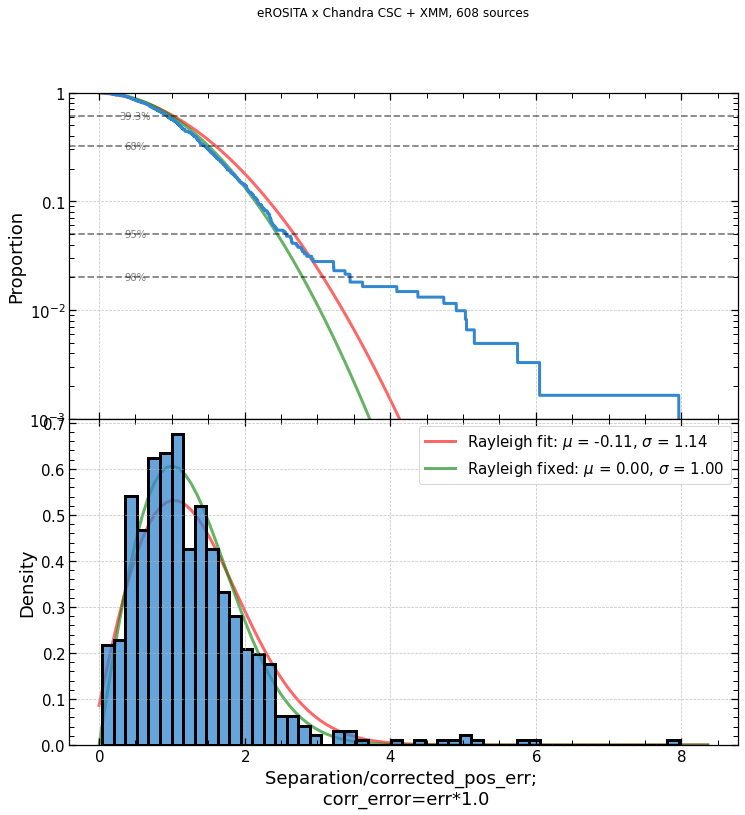

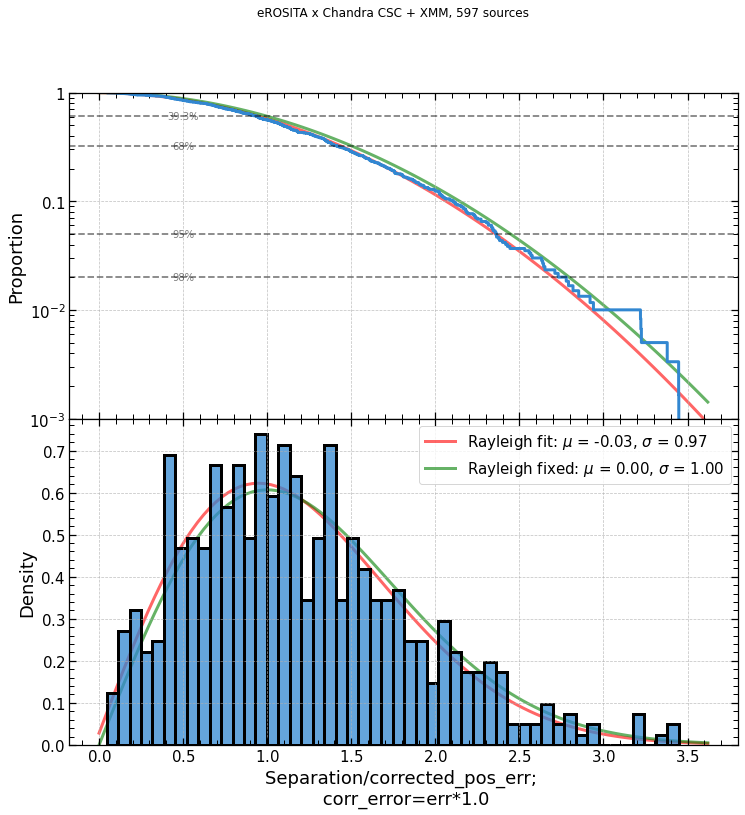

In [18]:
from scripts.cross_match_scripts import rayleigh_plot
rayleigh_plot(final_ctps, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')
rayleigh_plot(final_ctps_cut, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')



In [764]:
# old_companions = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
# old_companions.ID = old_companions.ID.str.decode('utf-8')
# old_companions.desi_id_true_ctp = old_companions.desi_id_true_ctp.str.decode('utf-8')
# old_companions.rename(columns = {'ID':'srcname_fin', 'desi_id_true_ctp': 'desi_id'}, inplace = True)

# old_companions.sort_values(by='srcname_fin', inplace=True)
# old_companions.reset_index(drop=True, inplace=True)
# old_companions = old_companions[old_companions.desi_id!='hostless']

# # old_companions = old_companions.merge(desi[['ra', 'dec', 'desi_id']], on='desi_id', how='left')

# # old_companions = old_companions.merge(ero_df[['RA_fin', 'DEC_fin', 'pos_sigma_2d', 'srcname_fin']], on='srcname_fin', how='left')

# # old_companions = add_separation_columns(old_companions, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'ra', colname_dec2 = 'dec', colname = 'sep_ero_desi')

# # old_companions

# # from scripts.cross_match_scripts import rayleigh_plot
# # rayleigh_plot(old_companions, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='old validation cat', pos_err_corr_func=lambda x: 0.9*x)
